In [1]:
import os
os.environ['KERAS_BACKEND']='theano' # 也可以使用 tensorflow
os.environ['THEANO_FLAGS']='floatX=float32,device=cuda'

使用 WGAN https://github.com/martinarjovsky/WassersteinGAN paper 的模型

In [2]:
import keras.backend as K
K.set_image_data_format('channels_first')
from keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, BatchNormalization, Input
from keras.layers import Conv2DTranspose, Reshape, Activation, Cropping2D, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal
conv_init = RandomNormal(0, 0.02)
gamma_init = RandomNormal(1., 0.02)


Using Theano backend.
Using cuDNN version 5105 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:01:00.0)


跟官方的差異是
* 沒有使用 extra_layers (只是因為沒有用到，可以加入)
* 圖形計算的大小有差異，如果是 $ isize = 2^n$ 是一樣的。


參數改用 pytroch 預設值

In [3]:
def DCGAN_D(isize, nz, nc, ndf, n_extra_layers=0):
    _ = inputs = Input(shape=(nc, isize, isize))
    _ = ZeroPadding2D(padding=1, name = 'initial.padding.{0}'.format(nc))(_)
    _ = Conv2D(filters=ndf, kernel_size=4, strides=2, use_bias=False,
                        kernel_initializer = conv_init, 
                        name = 'initial.conv.{0}-{1}'.format(nc, ndf)             
                        ) (_)
    _ = LeakyReLU(alpha=0.2, name = 'initial.relu.{0}'.format(ndf))(_)
    csize, cndf = isize // 2, ndf
    while csize > 5:
        in_feat = cndf
        out_feat = cndf*2
        _ = ZeroPadding2D(padding=1, name = 'pyramid.{0}.padding'.format(in_feat))(_)
        _ = Conv2D(filters=out_feat, kernel_size=4, strides=2, use_bias=False,
                        kernel_initializer = conv_init,
                        name = 'pyramid.{0}-{1}.conv'.format(in_feat, out_feat)             
                        ) (_)        
        _ = BatchNormalization(name = 'pyramid.{0}.batchnorm'.format(out_feat),                                   
                                   momentum=0.9, axis=1, epsilon=1.01e-5,
                                   gamma_initializer = gamma_init, 
                                  )(_, training=1)        
        _ = LeakyReLU(alpha=0.2, name = 'pyramid.{0}.relu'.format(out_feat))(_)
        csize, cndf = csize//2, cndf*2
    _ = Conv2D(filters=1, kernel_size=csize, strides=1, use_bias=False,
                        kernel_initializer = conv_init,
                        name = 'final.{0}-{1}.conv'.format(cndf, 1)         
                        ) (_)
    outputs = Flatten()(_)
    return Model(inputs=inputs, outputs=outputs)


In [4]:
def DCGAN_G(isize, nz, nc, ngf, n_extra_layers=0):
    cngf= ngf//2
    tisize = isize
    while tisize > 5:
        cngf = cngf * 2
        tisize = tisize // 2
    _ = inputs = Input(shape=(nz,))
    _ = Reshape((nz, 1,1))(_)
    _ = Conv2DTranspose(filters=cngf, kernel_size=tisize, strides=1, use_bias=False,
                           kernel_initializer = conv_init, 
                           name = 'initial.{0}-{1}.convt'.format(nz, cngf))(_)
    _ = BatchNormalization(gamma_initializer = gamma_init, momentum=0.9, axis=1, epsilon=1.01e-5,
                               name = 'initial.{0}.batchnorm'.format(cngf))(_, training=1)
    _ = Activation("relu", name = 'initial.{0}.relu'.format(cngf))(_)
    csize, cndf = tisize, cngf
    

    while csize < isize//2:
        in_feat = cngf
        out_feat = cngf//2
        _ = Conv2DTranspose(filters=out_feat, kernel_size=4, strides=2, use_bias=False,
                        kernel_initializer = conv_init,
                        name = 'pyramid.{0}-{1}.convt'.format(in_feat, out_feat)             
                        ) (_)
        _ = Cropping2D(cropping=1,
                             name = 'pyramid.{0}.cropping'.format(in_feat) )(_)
        _ = BatchNormalization(gamma_initializer = gamma_init, 
                                   momentum=0.9, axis=1, epsilon=1.01e-5,
                                   name = 'pyramid.{0}.batchnorm'.format(out_feat))(_, training=1)
        
        _ = Activation("relu", name = 'pyramid.{0}.relu'.format(out_feat))(_)
        csize, cngf = csize*2, cngf//2
    _ = Conv2DTranspose(filters=nc, kernel_size=4, strides=2, use_bias=False,
                        kernel_initializer = conv_init,
                        name = 'final.{0}-{1}.convt'.format(cngf, nc)
                        )(_)
    _ = Cropping2D(cropping=1,
                             name = 'final.{0}.cropping'.format(nc) )(_)
    outputs = Activation("tanh", name = 'final.{0}.tanh'.format(nc))(_)
    return Model(inputs=inputs, outputs=outputs)


除了圖片大小外，參數皆為 WGAN 預設的數值。

In [5]:
nc = 3
nz = 100
ngf = 64
ndf = 64
n_extra_layers = 0
Diters = 5

imageSize = 32
batchSize = 64
lrD = 0.00005
lrG = 0.00005
clamp_lower, clamp_upper = -0.01, 0.01


顯示一下模型

In [6]:
netD = DCGAN_D(imageSize, nz, nc, ndf, n_extra_layers)
netD.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 32, 32)         0         
_________________________________________________________________
initial.padding.3 (ZeroPaddi (None, 3, 34, 34)         0         
_________________________________________________________________
initial.conv.3-64 (Conv2D)   (None, 64, 16, 16)        3072      
_________________________________________________________________
initial.relu.64 (LeakyReLU)  (None, 64, 16, 16)        0         
_________________________________________________________________
pyramid.64.padding (ZeroPadd (None, 64, 18, 18)        0         
_________________________________________________________________
pyramid.64-128.conv (Conv2D) (None, 128, 8, 8)         131072    
_________________________________________________________________
pyramid.128.batchnorm (Batch (None, 128, 8, 8)         512       
__________

In [7]:
netG = DCGAN_G(imageSize, nz, nc, ngf, n_extra_layers)
netG.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 100, 1, 1)         0         
_________________________________________________________________
initial.100-256.convt (Conv2 (None, 256, 4, 4)         409600    
_________________________________________________________________
initial.256.batchnorm (Batch (None, 256, 4, 4)         1024      
_________________________________________________________________
initial.256.relu (Activation (None, 256, 4, 4)         0         
_________________________________________________________________
pyramid.256-128.convt (Conv2 (None, 128, 10, 10)       524288    
_________________________________________________________________
pyramid.256.cropping (Croppi (None, 128, 8, 8)         0         
__________

In [8]:
from keras.optimizers import RMSprop, SGD

這是 netD 的 weight clipping

In [9]:
clamp_updates = [K.update(v, K.clip(v, clamp_lower, clamp_upper))
                          for v in netD.trainable_weights]
netD_clamp = K.function([],[], clamp_updates)

下面是訓練 netD 用的。 一部分吃真正的圖形，一部分吃生成的圖形

In [10]:
netD_real_input = Input(shape=(nc, imageSize, imageSize))
netD_real = Model(inputs=netD_real_input, outputs=netD(netD_real_input))

netD_fake_input = Input(shape=(nc, imageSize, imageSize))
netD_fake = Model(inputs=netD_fake_input, outputs=netD(netD_fake_input))

netD_real_fake = Model(inputs=[netD_real_input, netD_fake_input],                        
                       outputs=netD_real.outputs+ netD_fake.outputs)

然後計算 Wasserstein distance， 並且設定 rmsprop 訓練函數

In [11]:
loss_real = K.mean(netD_real_fake.outputs[0])
loss_fake = K.mean(netD_real_fake.outputs[1])
loss = loss_real - loss_fake
optimizer = RMSprop(lr=lrD, rho=0.99)
training_updates = optimizer.get_updates(netD_real_fake.trainable_weights,[],loss)
netD_train = K.function(
    netD_real_fake.inputs,  #+ [K.learning_phase()],
    [loss_real, loss_fake],
    netD_real_fake.updates+training_updates)

下面是訓練 netG 使用，用 netG 生出圖片，算出對應的 loss

In [12]:
noisev = Input(shape=(nz,))
fake = netG(noisev)
optimizer=RMSprop(lr=lrG, rho=0.99)

net_combined = Model(noisev, netD(fake))

loss = K.mean(net_combined.outputs[0])

optimizer = RMSprop(lr=lrG, rho=0.99)

training_updates = optimizer.get_updates(netG.trainable_weights,[],loss)

netG_train = K.function(
    net_combined.inputs, # + [K.learning_phase()],
    [loss],
    net_combined.updates + training_updates)


一樣下載 cifar10 檔案

In [13]:
from PIL import Image
import numpy as np
import tarfile

# 下載 dataset
url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
import os
import urllib
from urllib.request import urlretrieve
def reporthook(a,b,c):
    print("\rdownloading: %5.1f%%"%(a*b*100.0/c), end="")
tar_gz = "cifar-10-python.tar.gz"
if not os.path.isfile(tar_gz):
        print('Downloading data from %s' % url)
        urlretrieve(url, tar_gz, reporthook=reporthook)

import pickle
train_X=[]
train_y=[]
tar_gz = "cifar-10-python.tar.gz"
with tarfile.open(tar_gz) as tarf:
    for i in range(1, 6):
        dataset = "cifar-10-batches-py/data_batch_%d"%i
        print("load",dataset)
        with tarf.extractfile(dataset) as f:
            result = pickle.load(f, encoding='latin1')
        train_X.extend( result['data'].reshape(-1,3,32,32)/255*2-1)
        train_y.extend(result['labels'])
    train_X=np.float32(train_X)
    train_y=np.int32(train_y)
    dataset = "cifar-10-batches-py/test_batch"
    print("load",dataset)
    with tarf.extractfile(dataset) as f:
        result = pickle.load(f, encoding='latin1')
        test_X=np.float32(result['data'].reshape(-1,3,32,32)/255*2-1)
        test_y=np.int32(result['labels'])
        

load cifar-10-batches-py/data_batch_1
load cifar-10-batches-py/data_batch_2
load cifar-10-batches-py/data_batch_3
load cifar-10-batches-py/data_batch_4
load cifar-10-batches-py/data_batch_5
load cifar-10-batches-py/test_batch


讓輸入的資料多一點，加入 test_X，左右鏡射

In [14]:
train_X = np.concatenate([train_X, test_X])
train_X = np.concatenate([train_X[:,:,:,::-1], train_X, test_X])

一樣的工具函數

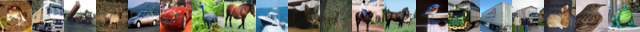

[6 9 9 4 1 1 2 7 8 3 4 7 7 2 9 9 9 3 2 6]
['青蛙' '卡車' '卡車' '鹿' '汽車' '汽車' '鳥' '馬' '船' '貓' '鹿' '馬' '馬' '鳥' '卡車' '卡車'
 '卡車' '貓' '鳥' '青蛙']


In [15]:
from IPython.display import display
def showX(X, rows=1):
    assert X.shape[0]%rows == 0
    int_X = ( (X+1)/2*255).clip(0,255).astype('uint8')
    # N*3072 -> N*3*32*32 -> 32 * 32N * 3
    int_X = np.moveaxis(int_X.reshape(-1,3,32,32), 1, 3)
    int_X = int_X.reshape(rows, -1, 32, 32,3).swapaxes(1,2).reshape(rows*32,-1, 3)
    display(Image.fromarray(int_X))
# 訓練資料， X 的前 20 筆
showX(train_X[:20])
print(train_y[:20])
name_array = np.array("飛機、汽車、鳥、貓、鹿、狗、青蛙、馬、船、卡車".split('、'))
print(name_array[train_y[:20]])

In [ ]:
# 用來查看成果的亂數
fixed_noise = np.random.normal(size=(batchSize, nz)).astype('float32')

[2/100][740/2031][500] Loss_D: -0.498519 Loss_G: 0.247432 Loss_D_real: -0.250390 Loss_D_fake 0.248129 79.66276478767395


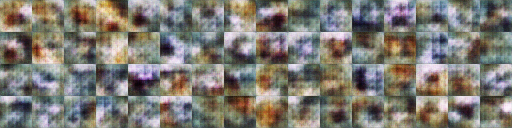

[3/100][1300/2031][1000] Loss_D: -0.373974 Loss_G: 0.186617 Loss_D_real: -0.191045 Loss_D_fake 0.182929 121.67833852767944


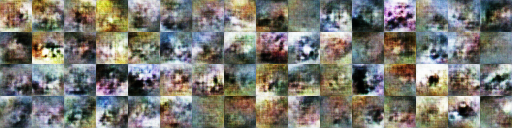

[4/100][1860/2031][1500] Loss_D: -0.313909 Loss_G: 0.151613 Loss_D_real: -0.167205 Loss_D_fake 0.146704 163.62784385681152


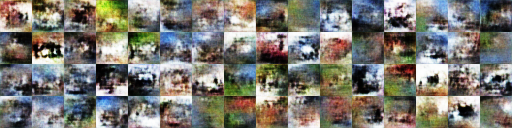

[6/100][385/2031][2000] Loss_D: -0.260247 Loss_G: 0.153175 Loss_D_real: -0.150209 Loss_D_fake 0.110037 207.77218008041382


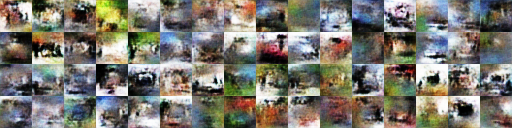

[7/100][945/2031][2500] Loss_D: -0.242169 Loss_G: 0.124051 Loss_D_real: -0.113442 Loss_D_fake 0.128727 249.91855573654175


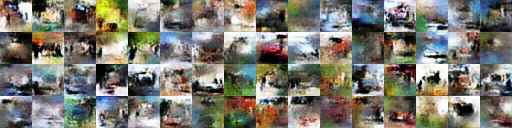

[8/100][1505/2031][3000] Loss_D: -0.225769 Loss_G: 0.140542 Loss_D_real: -0.108636 Loss_D_fake 0.117132 291.9917461872101


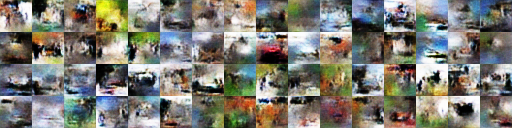

In [ ]:
import time
t0 = time.time()
niter = 100
gen_iterations = 0
targetD = np.float32([2]*batchSize+[-2]*batchSize)[:, None]
targetG = np.ones(batchSize, dtype=np.float32)[:, None]
for epoch in range(niter):
    i = 0
    #  每個 epoch 洗牌一下
    np.random.shuffle(train_X)
    batches = train_X.shape[0]//batchSize
    while i < batches:
        if gen_iterations < 25 or gen_iterations %500 == 0:
            _Diters = 100
        else:
            _Diters = Diters
        j = 0
        while j < _Diters and i < batches:
            j+=1
            netD_clamp([])
            real_data = train_X[i*batchSize:(i+1)*batchSize]
            i+=1
            # 這裡與官方有差異，在這裡生成時 netG 的 batchNormalization 是用 training 的行為
            fake_data = netG.predict(np.random.normal(size=(batchSize, nz)))
            errD_real, errD_fake  = netD_train([real_data, fake_data])
            errD = errD_real - errD_fake
        noise = np.random.normal(size=(batchSize, nz))        
        # 這裡與官方相同， netD 和 netG 的 batchNormalization  都是是用 training 的行為
        errG, = netG_train([noise])
        gen_iterations+=1        
        if gen_iterations%500==0:
            print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake %f'
            % (epoch, niter, i, batches, gen_iterations,errD, errG, errD_real, errD_fake), time.time()-t0)
        if gen_iterations%500 == 0:            
            # 這裡與官方有差異，在這裡生成時 netG 的 batchNormalization 是用 training 的行為
            fake = netG.predict(fixed_noise)
            showX(fake, 4)
        